In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm
from heapq import heappush, heappop
from collections import defaultdict

data_path = 'data/'

In [2]:
adj_list = pd.read_csv(data_path+'Adj_list_bbike_map.csv')
nodes = pd.read_csv(data_path+'Nodes_bbike_map.csv')

In [3]:
graph = nodes.merge(adj_list, left_on='osmid', right_on='Source')
adj = graph.iloc[:,5:].to_numpy()
adj = [node[~np.isnan(node)] for node in adj]
graph['adj'] = adj
graph = graph[['osmid','x','y','name','adj']].set_index('osmid')

In [4]:
N = 100
obj_type = 'больница'

sample_nodes = graph[graph['name']=='нет'].sample(N, random_state=0)
sample_obj = graph[graph['name']==obj_type].sample(1, random_state=0)

In [5]:
def euclidean_dist(x1, y1, x2, y2):
    dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist

In [6]:
def df_to_edges(graph: pd.DataFrame):
    graph_dict = graph.T.to_dict()
    edges = defaultdict(list)
    
    for src_id, row_dict in graph_dict.items():
        src_x = row_dict['x']
        src_y = row_dict['y']
        
        for dst_id in row_dict['adj']:
            dst_x = graph_dict[dst_id]['x']
            dst_y = graph_dict[dst_id]['y']
            cost = euclidean_dist(src_x, src_y, dst_x, dst_y)
            
            edges[src_id].append((cost, dst_id))
            
    return edges

In [7]:
def dijkstra(graph : pd.DataFrame, src : int, dst : set):
    edges = df_to_edges(graph)
    mins = {vertex : {'cost' : np.inf, 'path' : ()} for vertex in graph.index}
    mins[src] = 0
    seen = set()
    dst_control = dst.copy()
    
    queue = [(0, src, ())]
    while queue and dst_control:
        (cost1, vertex1, path) = heappop(queue)
        
        if vertex1 not in seen:
            seen.add(vertex1)
            dst_control.discard(vertex1)
            path = path+tuple([vertex1])

            for cost2, vertex2 in edges.get(vertex1, ()):
                if vertex2 in seen: 
                    continue
                    
                prev = mins.get(vertex2, None)['cost']
                curr = cost1 + cost2
                
                if prev is None or curr < prev:
                    mins[vertex2] = {
                        'cost' : curr,
                        'path' : path
                    }
                    heappush(queue, (curr, vertex2, path))
    
    mins = {vertex : cost_path for vertex, cost_path in mins.items() if vertex in dst}
    return mins 

In [8]:
import osmnx as ox 

G2_simp = ox.graph_from_file(data_path+'Rostov3_simp.osm', retain_all=True, simplify=False)

def plot_trees(G, trees):
    
    G_edges = list(G.edges())
    G_nodes = list(G.nodes())
    num_edges = len(G_edges)
    num_nodes = len(G_nodes)
    
    edge_color = ['gray'] * num_edges
    edge_linewidth = [1] * num_edges
    node_color = ['blue'] * num_nodes
    node_size = [0] * num_nodes
    ec = ['purple', 'blue', 'green', 'brown', 'violet', 'orange']
    
    mins_sum = 0
    tree_len = 0
    k = 0
    for tree in trees:
        mins = tree['mins']
        root = tree['root']
        costs = np.array([value['cost'] for value in mins.values()])
        costs = costs[costs != np.inf]
        mins_sum += sum(costs)

        tree = set()
        for source, value in mins.items():
            path = value['path']
            prev = source
            for node in path:
                tree.add((prev, node))
                prev = node

        tree_len += sum([euclidean_dist(nodes[nodes.osmid == osmid1]['x'].iloc[0], 
                                       nodes[nodes.osmid == osmid1]['y'].iloc[0], 
                                       nodes[nodes.osmid == osmid2]['x'].iloc[0], 
                                       nodes[nodes.osmid == osmid2]['y'].iloc[0]) for osmid1, osmid2 in tree])

        dst_nodes_index = list(mins.keys())

        edge_color = [ec[k] if G_edges[i] in tree else edge_color[i] for i in range(num_edges)]
        edge_linewidth = [5 if k == 0 and G_edges[i] in tree
                          else 3 if G_edges[i] in tree and edge_linewidth[i] == 1
                          else edge_linewidth[i] for i in range(num_edges)]
        if k == 0:
            node_color = ['red' if G_nodes[i] == root else node_color[i] for i in range(num_nodes)]
        node_size = [300 if G_nodes[i] == root else 50 if G_nodes[i] in dst_nodes_index and node_size[i] == 0
              else node_size[i] for i in range(num_nodes)]
        
        k += 1
    
    fig, ax = ox.plot_graph(G, edge_color=edge_color, 
                            edge_linewidth=edge_linewidth, 
                            node_color=node_color, 
                            node_size=node_size, 
                            fig_height=18)

    print('Tree len: ', tree_len)
    print('Mins sum: ', mins_sum)

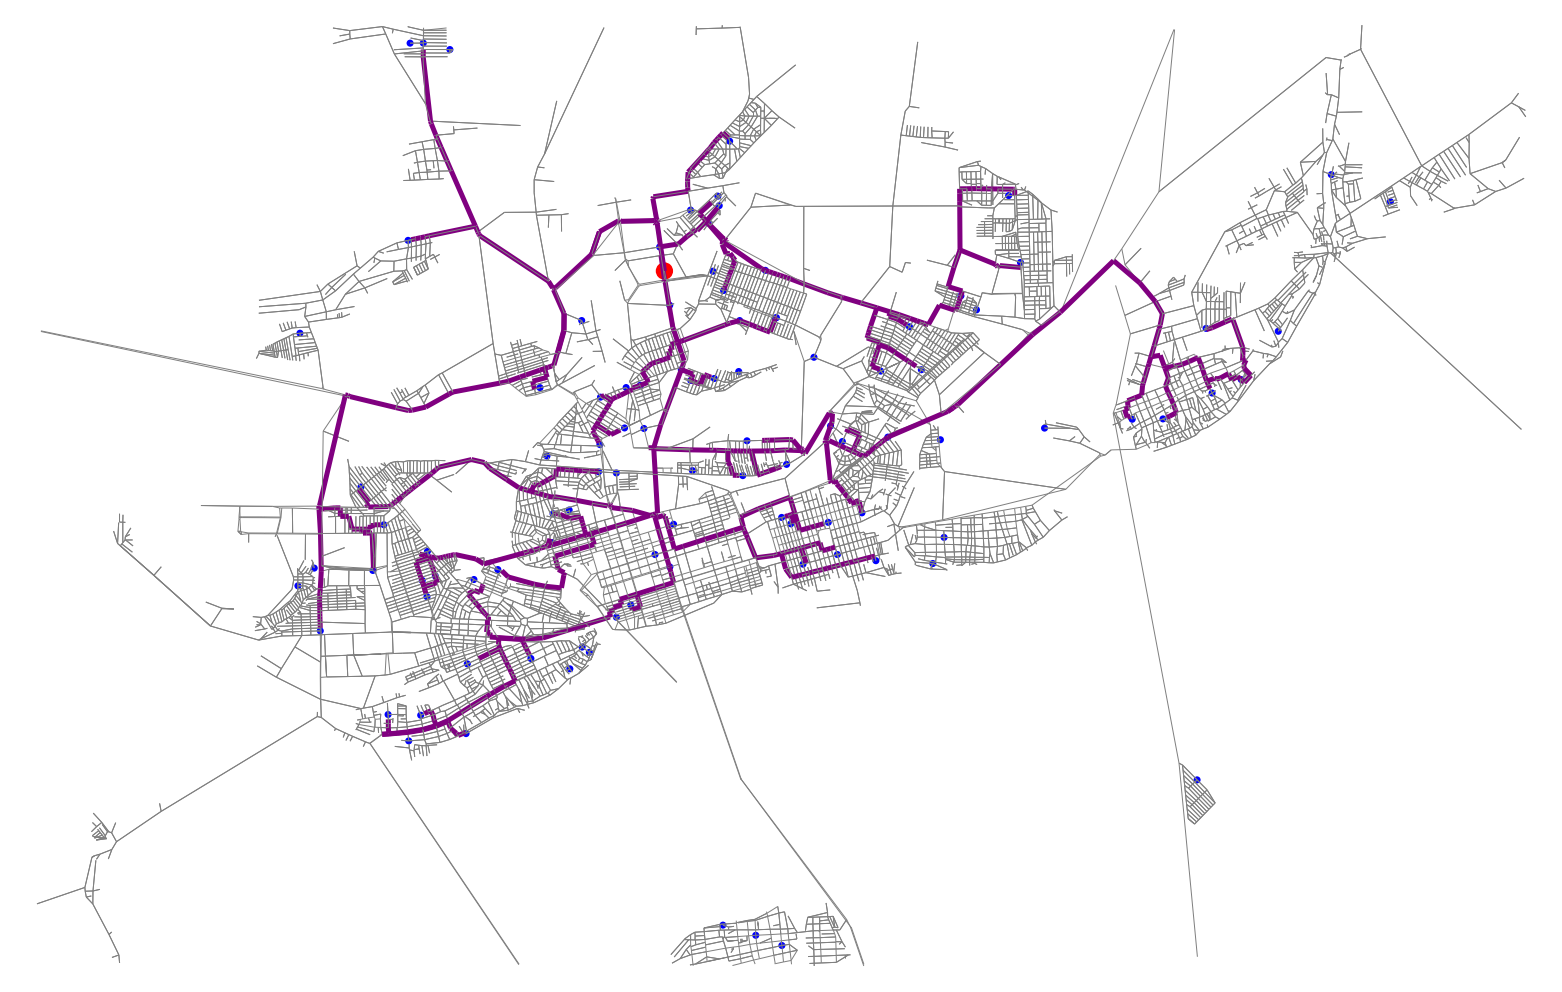

Tree len:  6.4812554182496696
Mins sum:  7.760861046678379


In [9]:
mins = dijkstra(graph, sample_obj.index[0], set(sample_nodes.index))
plot_trees(G2_simp, [{'mins' : mins, 'root' : sample_obj.index[0]}])

In [10]:

я бdef plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    dendrogram(linkage_matrix, **kwargs)

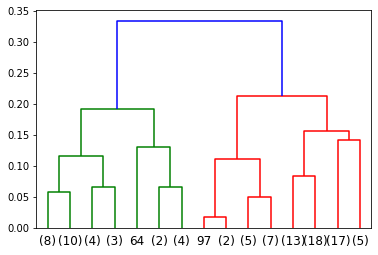

In [11]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

X = sample_nodes[['x','y']].to_numpy()
model = AgglomerativeClustering(distance_threshold=0, linkage='complete', n_clusters=None)
model = model.fit(X)
plot_dendrogram(model, truncate_mode='level', p=3)

In [12]:
def get_clustroid(cluster):
    mean = np.mean(cluster, axis=0)
    clustroid = np.argmin([euclidean_dist(*mean, x, y) for x, y in cluster])
    
    return clustroid

def plot_clustering_trees(G, graph : pd.DataFrame, sample_nodes : pd.DataFrame, sample_obj : pd.DataFrame, k):
    
    X = sample_nodes[['x','y']].to_numpy()
    sample_nodes_index = sample_nodes.index.to_numpy()
    clustroids_set = set()

    model = AgglomerativeClustering(distance_threshold=None, linkage='complete', n_clusters=k)
    model.fit(X)
        
    print('k: ', k)
    
    trees = []
    
    for cluster in range(k):
        cluster_X = X[model.labels_ == cluster]
        cluster_nodes_index = sample_nodes_index[model.labels_ == cluster]
        
        clustroid = cluster_nodes_index[get_clustroid(cluster_X)]
        cluster_nodes_index = set(cluster_nodes_index)
        cluster_nodes_index.discard(clustroid)
        clustroids_set.add(clustroid)
        
        mins_cluster = dijkstra(graph, clustroid, cluster_nodes_index)
        trees.append({'mins' : mins_cluster, 'root' : clustroid})
    
    root = sample_obj.index[0]
    mins_clustroids = dijkstra(graph, root, clustroids_set)
    trees.insert(0, {'mins' : mins_clustroids, 'root' : root})
    
    plot_trees(G, trees)

k:  5


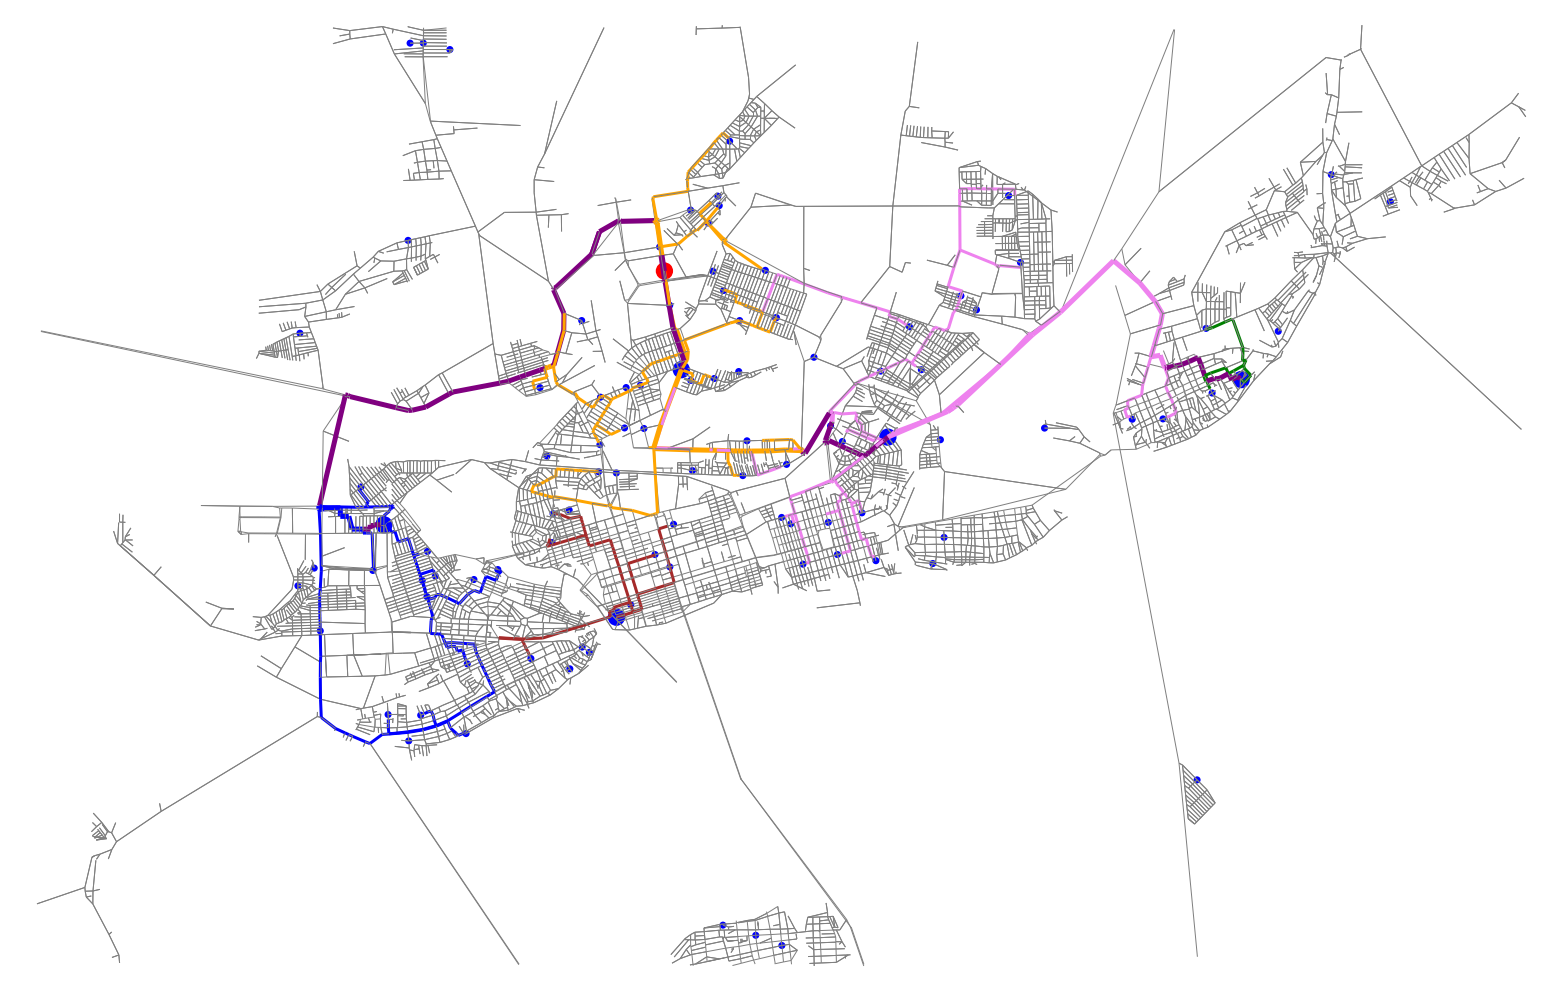

Tree len:  4.0938101235656195
Mins sum:  5.4327814542178166


In [18]:
plot_clustering_trees(G2_simp, graph, sample_nodes, sample_obj, k=5)